In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("Agg")
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa, IPython
import librosa.display as lplt
from scipy import io, misc
import scipy
import tensorflow as tf
import glob
from PIL import Image
import os
from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout)
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.optimizers import Adam
from keras.initializers import glorot_uniform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from keras.preprocessing.image import ImageDataGenerator
import random
import keras.backend as K
import keras
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
#Specify the parameters for the audio sample
duration_samples=0.2 #seconds
size_max=120000
frequence=10000 #Hertz

In [3]:
#load the audio files
file="dataset.mat"
dataset=scipy.io.loadmat(file)

df_normal=dataset["normal"].reshape(-1)[:size_max]
df_inner=dataset["inner"].reshape(-1)[:size_max]
df_roller=dataset["roller"].reshape(-1)[:size_max]
df_outer=dataset["outer"].reshape(-1)[:size_max]

data=[df_normal,df_inner,df_roller,df_outer]
print(df_outer.shape)


(120000,)


In [4]:
def load_data(train=0.7):
    type_track = 0
    n_samples_each = int(size_max/frequence/duration_samples)
    audios_train = []
    audios_test = []
    number_train=int(n_samples_each*0.7)

    for track in data:
        for i in range(0,n_samples_each):
            t1 = int(i*frequence*duration_samples)
            t2 = int((i+1)*frequence*duration_samples)
            new = list(track)[t1:t2]
            if i<number_train:
                audios_train.append((type_track,new))
            else:
                audios_test.append((type_track,new))
        type_track = type_track+1
    np.random.seed(1)
    np.random.shuffle(audios_train)
    np.random.seed(1)
    np.random.shuffle(audios_test)
    return [i[1] for i in audios_train], [i[1] for i in audios_test], [i[0] for i in audios_train], [i[0] for i in audios_test]

In [5]:
audios_train, audios_test, label_train, label_test = load_data()
print(len(audios_train),len(audios_test))

168 72


In [6]:
IPython.display.Audio(df_normal, rate=frequence)

In [7]:
IPython.display.Audio(df_inner, rate=frequence)

In [8]:
IPython.display.Audio(df_roller, rate=frequence)

In [9]:
IPython.display.Audio(df_outer, rate=frequence)

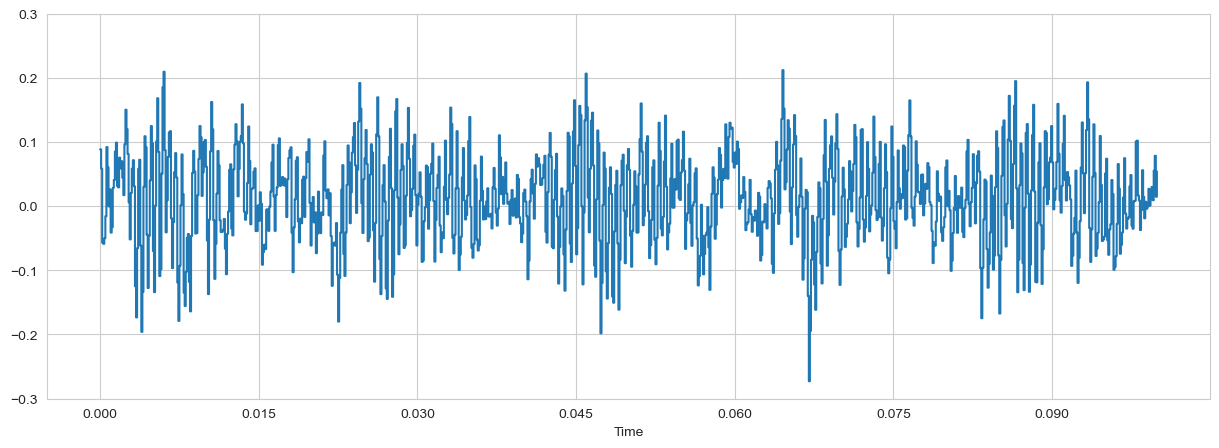

In [10]:
plt.figure(figsize=(15,5))
lplt.waveshow(df_normal[:1000], sr=frequence)
plt.show()

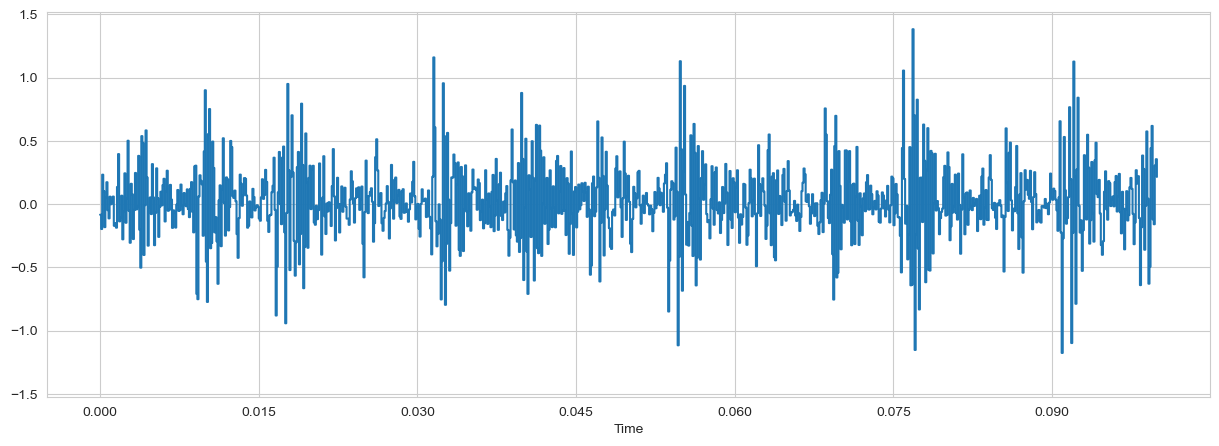

In [11]:
plt.figure(figsize=(15,5))
lplt.waveshow(df_inner[:1000], sr=frequence)
plt.show()

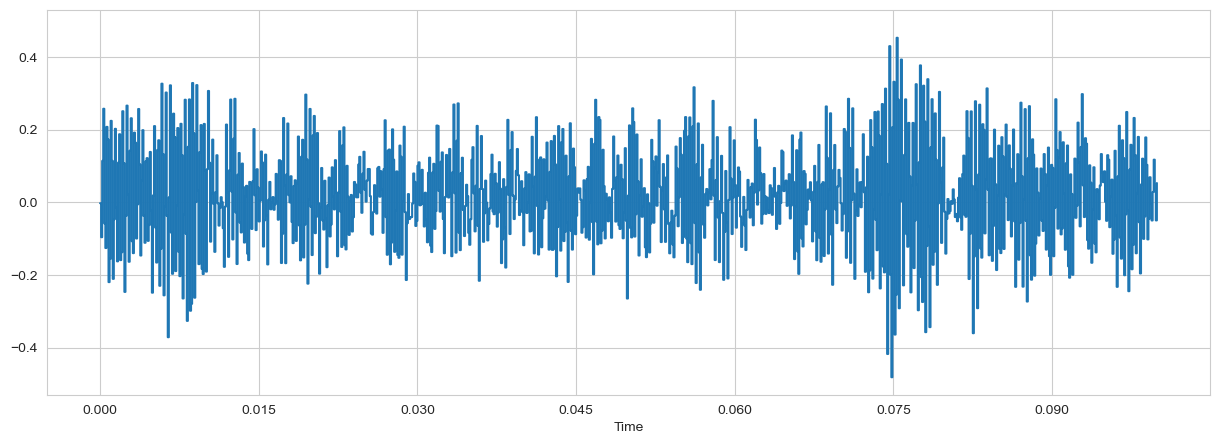

In [12]:
plt.figure(figsize=(15,5))
lplt.waveshow(df_roller[:1000], sr=frequence)
plt.show()

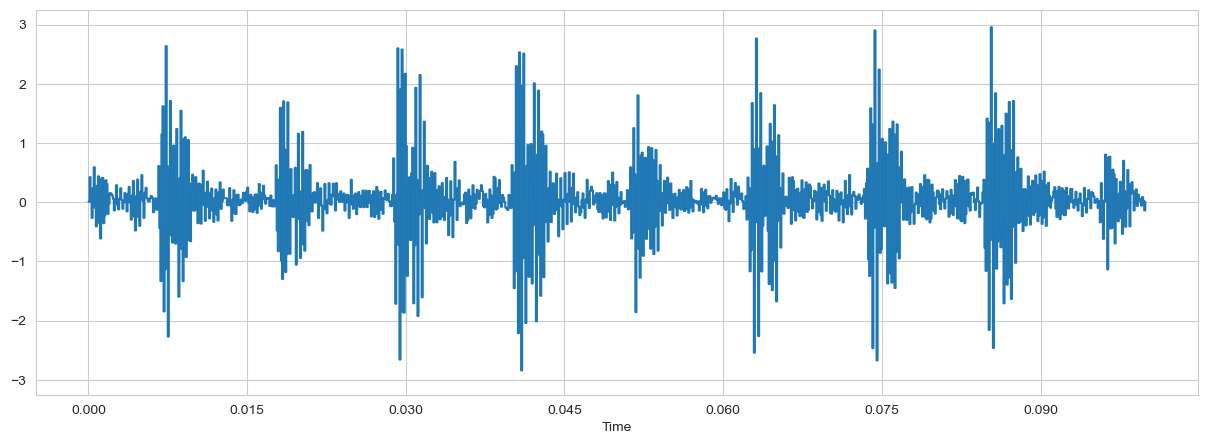

In [13]:
plt.figure(figsize=(15,5))
lplt.waveshow(df_outer[:1000], sr=frequence)
plt.show()

In [14]:
def processing_images(audios_train,audios_test):
    mels_train = []
    for audio in audios_train:
        n_fft = 2048 # window size
        hop_length = 512 # window hop length for STFT
        
        fig, ax = plt.subplots(figsize=(3, 2),dpi=72)
        stft = librosa.stft(np.asarray(audio), n_fft=n_fft, hop_length=hop_length)
        lplt.specshow(stft, sr=frequence, x_axis='time', y_axis='hz')
        plt.axis('off')
        fig.canvas.draw()
        data1 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        #print(len(fig.properties))
        #print(fig.properties())
        data1 = data1.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        fig, ax = plt.subplots(figsize=(3, 2),dpi=72)
        stft_db = librosa.amplitude_to_db(stft, ref=np.max)
        lplt.specshow(stft_db, sr=frequence, x_axis='time', y_axis='hz', cmap='cool')
        plt.axis('off')
        fig.canvas.draw()
        data2 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data2 = data2.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        fig, ax = plt.subplots(figsize=(3, 2),dpi=72)
        S,phase = librosa.magphase(librosa.stft(np.asarray(audio)))
        spectral = librosa.feature.spectral_contrast(S=S,sr=frequence,fmin=30)
        lplt.specshow(spectral, sr=frequence, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
        plt.axis('off')
        fig.canvas.draw()
        data3 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data3 = data3.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        fig, ax = plt.subplots(figsize=(3, 2),dpi=72)
        chroma = librosa.feature.chroma_stft(y=np.asarray(audio), sr=frequence)
        lplt.specshow(chroma, sr=frequence, x_axis='time', y_axis='chroma', cmap='coolwarm')
        plt.axis('off')
        fig.canvas.draw()
        data4 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data4 = data4.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        fig, ax = plt.subplots(figsize=(3, 2),dpi=72)
        mfccs = librosa.feature.mfcc(y=np.asarray(audio), sr=frequence, n_mfcc=20)
        lplt.specshow(mfccs, x_axis='time')
        plt.axis('off')
        fig.canvas.draw()
        data5 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data5 = data5.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        # print(data1.shape,data2.shape,data3.shape,data4.shape,data5.shape)
        mels_train.append(np.concatenate((data1,data2,data3,data4,data5),axis=0).reshape(720, 216, 3))

    mels_test = []
    for audio in audios_test:
        n_fft = 2048 # window size
        hop_length = 512 # window hop length for STFT

        fig, ax = plt.subplots(figsize=(3, 2),dpi=72)
        stft = librosa.stft(y=np.asarray(audio), n_fft=n_fft, hop_length=hop_length)
        lplt.specshow(stft, sr=frequence, x_axis='time', y_axis='hz')
        plt.axis('off')
        fig.canvas.draw()
        data1 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data1 = data1.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        fig, ax = plt.subplots(figsize=(3, 2),dpi=72)
        stft_db = librosa.amplitude_to_db(stft, ref=np.max)
        lplt.specshow(stft_db, sr=frequence, x_axis='time', y_axis='hz', cmap='cool')
        plt.axis('off')
        fig.canvas.draw()
        data2 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data2 = data2.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        fig, ax = plt.subplots(figsize=(3, 2),dpi=72)
        S,phase = librosa.magphase(librosa.stft(y=np.asarray(audio)))
        spectral = librosa.feature.spectral_contrast(S=S,sr=frequence,fmin=30)
        lplt.specshow(spectral, sr=frequence, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
        plt.axis('off')
        fig.canvas.draw()
        data3 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data3 = data3.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        fig, ax = plt.subplots(figsize=(3, 2),dpi=72)
        chroma = librosa.feature.chroma_stft(np.asarray(audio), sr=frequence)
        lplt.specshow(chroma, sr=frequence, x_axis='time', y_axis='chroma', cmap='coolwarm')
        plt.axis('off')
        fig.canvas.draw()
        data4 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data4 = data4.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        
        fig, ax = plt.subplots(figsize=(3, 2),dpi=72)
        mfccs = librosa.feature.mfcc(y=np.asarray(audio), sr=frequence, n_mfcc=20)
        lplt.specshow(mfccs, x_axis='time')
        plt.axis('off')
        fig.canvas.draw()
        data5 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data5 = data5.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        mels_test.append(np.concatenate((data1,data2,data3,data4,data5),axis=0).reshape(720, 216, 3))
        
    return mels_train, mels_test

In [ ]:
mels_train, mels_test = processing_images(audios_train,audios_test)

In [16]:
def CNNModel(input_shape,classes=4):
    X_input = Input(input_shape)
    
    X = Conv2D(4,kernel_size=(3,3),strides=(1,1))(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(8,kernel_size=(3,3),strides=(1,1))(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(16,kernel_size=(3,3),strides = (1,1))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(32,kernel_size=(3,3),strides = (1,1))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(64,kernel_size=(3,3),strides=(1,1))(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)
    
    X = Conv2D(128,kernel_size=(3,3),strides=(1,1))(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Flatten()(X)

    X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)

    model = Model(inputs=X_input,outputs=X,name='GenreModel')

    return model

In [17]:
lb = preprocessing.LabelBinarizer()
y_training = lb.fit_transform(label_train)

In [18]:
def get_precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
  
model = CNNModel(input_shape=(720, 216, 3),classes=4)
opt = Adam(learning_rate=0.005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=["accuracy",get_f1]) 
model.summary()

Model: "GenreModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 720, 216, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 718, 214, 8)       224       
                                                                 
 batch_normalization_1 (Batc  (None, 718, 214, 8)      32        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 718, 214, 8)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 359, 107, 8)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 357, 105, 16)      1

In [19]:
history = model.fit(x=np.asarray(mels_train), y=np.asarray(y_training),epochs=30, validation_split=0.2,shuffle=True,batch_size=len(mels_train),verbose=1)

Epoch 1/30
1/1 [==============================] - 15s 15s/step - loss: 1.5592 - accuracy: 0.2761 - get_f1: 0.3152 - val_loss: 58.2385 - val_accuracy: 0.1471 - val_get_f1: 0.1471
Epoch 2/30
1/1 [==============================] - 0s 349ms/step - loss: 21.2560 - accuracy: 0.2761 - get_f1: 0.2761 - val_loss: 65.1950 - val_accuracy: 0.5882 - val_get_f1: 0.5882
Epoch 3/30
1/1 [==============================] - 0s 342ms/step - loss: 22.7157 - accuracy: 0.4179 - get_f1: 0.4179 - val_loss: 140.6078 - val_accuracy: 0.3529 - val_get_f1: 0.3529
Epoch 4/30
1/1 [==============================] - 0s 350ms/step - loss: 27.5370 - accuracy: 0.2239 - get_f1: 0.2239 - val_loss: 163.9226 - val_accuracy: 0.3529 - val_get_f1: 0.3529
Epoch 5/30
1/1 [==============================] - 0s 346ms/step - loss: 10.2537 - accuracy: 0.2388 - get_f1: 0.2388 - val_loss: 135.0019 - val_accuracy: 0.3529 - val_get_f1: 0.3529
Epoch 6/30
1/1 [==============================] - 0s 339ms/step - loss: 5.0639 - accuracy: 0.5000 -

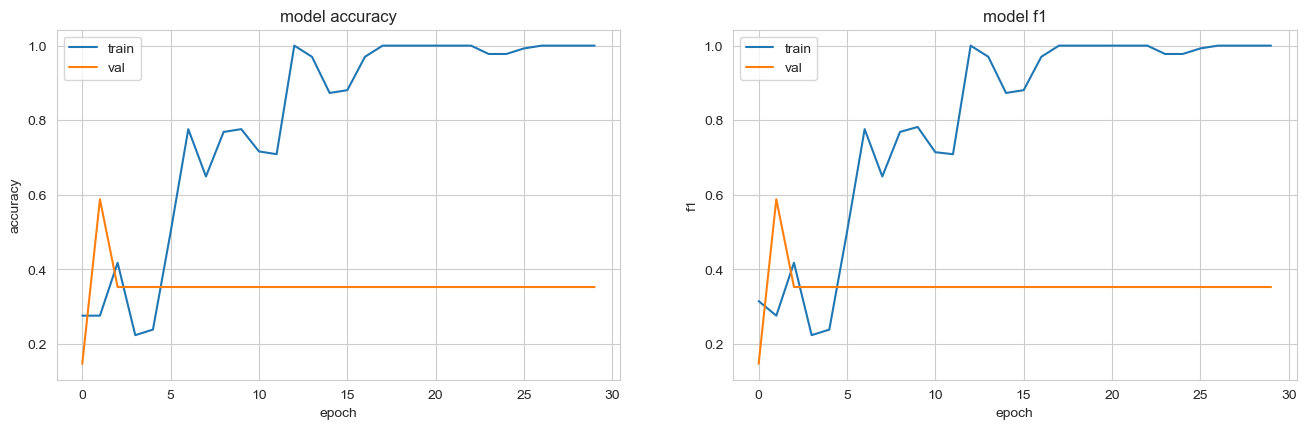

In [20]:
fig = plt.figure(figsize=(16,10))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')


plt.subplot(2, 2, 2)
plt.plot(history.history['get_f1'])
plt.plot(history.history['val_get_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
y_cnn = model.predict_generator(np.asarray(mels_test))
y_cnn = np.argmax(y_cnn,axis=1).tolist()

Accuracy:  0.25
Precision:  0.0625
Recall:  0.25
F1 score:  0.1


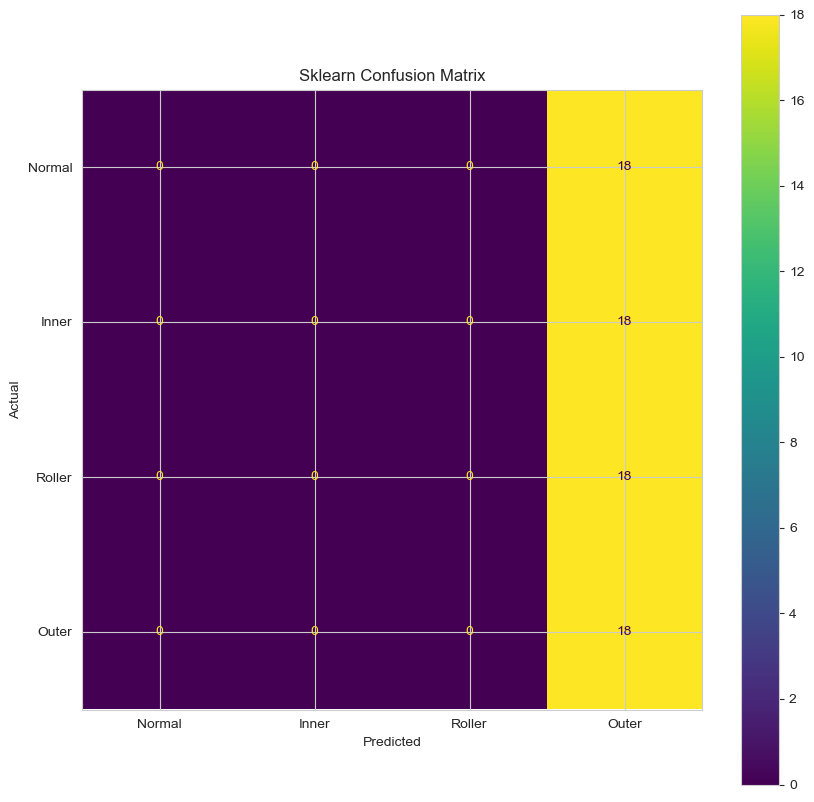

In [22]:
print("Accuracy: ",accuracy_score(label_test,y_cnn))
print("Precision: ",precision_score(label_test,y_cnn,average='macro'))
print("Recall: ",recall_score(label_test,y_cnn,average='macro'))
print("F1 score: ",f1_score(label_test,y_cnn,average='macro'))

cm = confusion_matrix(label_test, y_cnn)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Inner','Roller','Outer'])

fig, ax = plt.subplots(figsize=(10,10))
cmd_obj.plot(ax=ax)

cmd_obj.ax_.set(title='Sklearn Confusion Matrix', xlabel='Predicted', ylabel='Actual')
plt.show()

In [23]:
def feature_extract(row):
    ls_mean = []
    ls_var =[]
    pitches = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
    
    try:
        y = np.array(row)
        sr = frequence
        
        length = len(y)/sr
        
        mean_stft = np.mean(librosa.feature.chroma_stft(y=y,sr=sr))
        var_stft = np.var(librosa.feature.chroma_stft(y=y,sr=sr))
        tempo = librosa.beat.tempo(y,sr=sr)[0]
        
        S,phase = librosa.magphase(librosa.stft(y))
        rms = librosa.feature.rms(S=S)
        rms_mean = np.mean(rms)
        rms_var = np.var(rms)
        
        centroid = librosa.feature.spectral_centroid(S=S)
        centroid_mean = np.mean(centroid)
        centroid_var = np.var(centroid)
        
        bandwidth = librosa.feature.spectral_bandwidth(S=S)
        bandwidth_mean = np.mean(bandwidth)
        bandwidth_var = np.var(bandwidth)
        
        rolloff = librosa.feature.spectral_rolloff(y=y,sr=sr,roll_percent=0.85)
        rolloff_mean = np.mean(rolloff)
        rolloff_var = np.var(rolloff)
        
        zerocrossing = librosa.feature.zero_crossing_rate(y=y)
        crossing_mean = np.mean(zerocrossing)
        crossing_var = np.var(zerocrossing)
        
        y_harmonic = librosa.effects.harmonic(y=y)
        harmonic_mean = np.mean(y_harmonic)
        harmonic_var = np.var(y_harmonic)
        
        contrast = librosa.feature.spectral_contrast(S=S,sr=sr,fmin=5)
        contrast_mean = np.mean(contrast)
        contrast_var = np.var(contrast)
        mfcc= librosa.feature.mfcc(y=y,sr=sr)
        for i in range(0,20):
            ls_mean.append(np.mean(mfcc[i]))
            ls_var.append(np.var(mfcc[i]))
            
        key = librosa.feature.chroma_stft(y=y,sr=sr).sum(axis=1).argmax()
        key_name = pitches[librosa.feature.chroma_stft(y=y,sr=sr).sum(axis=1).argmax()]
        
        if librosa.feature.chroma_stft(y=y,sr=sr).sum(axis=1)[(key+3)%12] > librosa.feature.chroma_stft(y=y,sr=sr).sum(axis=1)[(key+4)%12]:
             scale = 'minor'
        else:
             scale = 'Major'
        
    except Exception as e: 
        print(e)
        length = 0
        mean_stft =0
        var_stft = 0
        tempo=0
        rms_mean =0 
        rms_var= 0
        centroid_mean=0
        centroid_var=0
        bandwidth_mean =0
        bandwidth_var=0
        rolloff_mean = 0
        rolloff_var = 0
        crossing_mean = 0
        crossing_var = 0
        harmonic_mean=0
        harmonic_var =0
        contrast_mean = 0
        contrast_var =0
        key = 0
        key_name=0
        scale =0
        
        for i in range(0,20):
            ls_mean.append(0) 
            ls_var.append(0)
        
    return [length,mean_stft,var_stft,tempo,rms_mean,rms_var,centroid_mean,centroid_var,\
bandwidth_mean,bandwidth_var,rolloff_mean,rolloff_var, crossing_mean,crossing_var,\
harmonic_mean,harmonic_var,contrast_mean,contrast_var,key,key_name,scale,ls_mean[0],ls_var[0],ls_mean[1],ls_var[1],ls_mean[2],ls_var[2],\
ls_mean[3],ls_var[3],ls_mean[4],ls_var[4],ls_mean[5],ls_var[5],ls_mean[6],ls_var[6],ls_mean[7],ls_var[7],ls_mean[8],ls_var[8],\
ls_mean[9],ls_var[9],ls_mean[10],ls_var[10],ls_mean[11],ls_var[11],ls_mean[12],ls_var[12],ls_mean[13],ls_var[13],ls_mean[14],ls_var[14],\
ls_mean[15],ls_var[15],ls_mean[16],ls_var[16],ls_mean[17],ls_var[17],ls_mean[18],ls_var[18],ls_mean[19],ls_var[19]]

In [24]:
columns=['length','mean_stft','var_stft','tempo','rms_mean','rms_var','centroid_mean','centroid_var',\
'bandwidth_mean','bandwidth_var','rolloff_mean','rolloff_var', 'crossing_mean','crossing_var',\
'harmonic_mean','harmonic_var','contrast_mean','contrast_var','key','key_name','scale','mfcc1_mean','mfcc1_var','mfcc2_mean','mfcc2_var','mfcc3_mean','mfcc3_var','mfcc4_mean','mfcc4_var',\
        'mfcc5_mean','mfcc5_var','mfcc6_mean','mfcc6_var','mfcc7_mean','mfcc7_var','mfcc8_mean','mfcc8_var',\
        'mfcc9_mean','mfcc9_var','mfcc10_mean','mfcc10_var','mfcc11_mean','mfcc11_var','mfcc12_mean','mfcc12_var',\
        'mfcc13_mean','mfcc13_var','mfcc14_mean','mfcc14_var','mfcc15_mean','mfcc15_var','mfcc16_mean','mfcc16_var',\
        'mfcc17_mean','mfcc17_var','mfcc18_mean','mfcc18_var','mfcc19_mean','mfcc19_var','mfcc20_mean','mfcc20_var']

In [25]:
df_train = pd.DataFrame()
for audio in audios_train:
    df_new = pd.DataFrame(feature_extract(audio)).T
    df_train = pd.concat([df_train,df_new])
    
df_train.reset_index(drop=True,inplace=True)
df_train.columns = columns

df_test = pd.DataFrame()
for audio in audios_test:
    df_new = pd.DataFrame(feature_extract(audio)).T
    df_test = pd.concat([df_test,df_new])
    
df_test.reset_index(drop=True,inplace=True)
df_test.columns = columns

In [26]:
df_train

,length,mean_stft,var_stft,tempo,rms_mean,rms_var,centroid_mean,centroid_var,bandwidth_mean,bandwidth_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.2,0.19089,0.074061,146.484375,0.042246,0.000034,3200.115785,4381.69461,2471.132681,259.173914,...,-21.800022,0.17429,5.168143,1.530122,5.385293,0.806671,-7.083903,0.928594,2.2486,1.317586
1,0.2,0.259094,0.083136,146.484375,0.377753,0.001097,5884.706119,4011.106271,1813.621417,5998.669717,...,5.783872,10.323973,-22.385307,50.226805,22.053512,13.960791,4.511887,4.888725,2.894588,12.622414
2,0.2,0.190927,0.072191,146.484375,0.041325,0.000037,3230.719516,3223.6593,2478.690959,931.675205,...,-19.544586,2.369922,9.30145,3.619377,6.334614,3.916781,-8.626326,0.365216,3.670842,3.840074
3,0.2,0.255284,0.083388,146.484375,0.393399,0.00261,5851.874667,4819.061894,1760.419794,10280.49834,...,4.05999,1.888587,-21.577659,57.176372,15.294087,7.183792,2.068365,22.766543,1.31135,3.38722
4,0.2,0.277637,0.094327,146.484375,0.074896,0.000128,4941.202927,986.407985,2069.753515,4274.69592,...,-5.818024,7.309674,-13.189334,10.90666,8.009549,5.55644,10.729591,6.635398,-13.070341,11.170635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.2,0.250897,0.080296,146.484375,0.370669,0.000921,5827.236191,1158.756369,1756.680056,108.909968,...,7.819723,0.558205,-26.744431,28.309636,25.06475,0.100649,1.106541,7.666736,3.549273,0.596491
164,0.2,0.258269,0.084166,146.484375,0.367175,0.001162,5837.518003,1245.522182,1777.252056,288.799722,...,11.419699,2.599169,-18.633424,27.488311,30.505704,1.749188,-0.04528,8.030937,-0.952856,0.995513
165,0.2,0.517413,0.101307,146.484375,0.162818,0.000385,4885.230869,1211.764197,2137.411694,202.29424,...,12.27599,1.478001,-23.644226,6.547065,12.854588,1.724926,-3.858597,4.072618,-0.706567,1.854294
166,0.2,0.24707,0.079687,146.484375,0.376282,0.001474,5802.328236,2948.323067,1750.992323,1005.991296,...,7.730385,13.411461,-27.462219,21.339356,24.212542,0.400804,-0.029721,2.0645,6.165937,1.043439


In [27]:
corr_df = pd.concat([df_train,pd.DataFrame(label_train)],axis=1)
corr_df = corr_df.rename(columns={0: "type"})

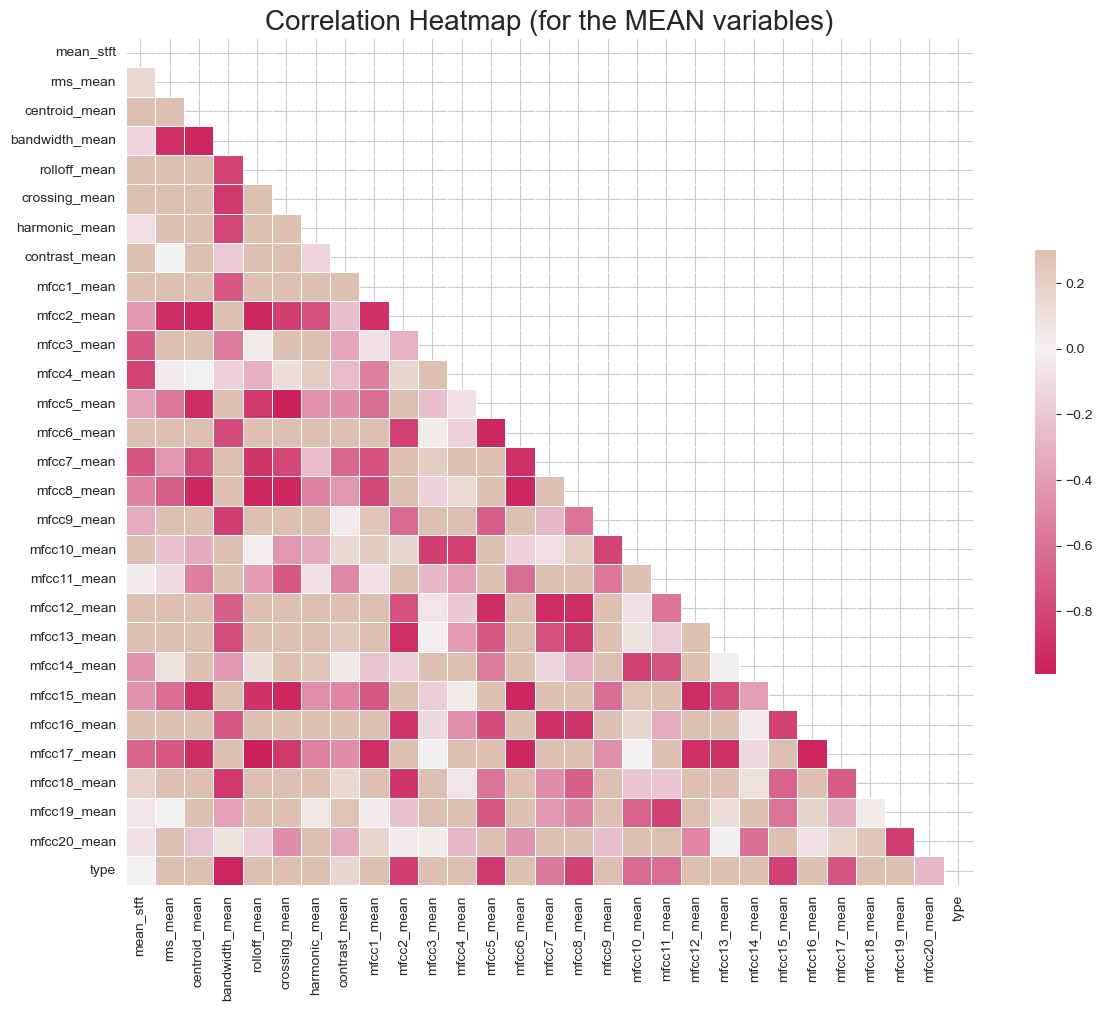

In [28]:
# Computing the Correlation Matrix
spike_cols = [col for col in corr_df.columns if ('mean' in col or 'type' in col)]
corr = corr_df[spike_cols].astype(float).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

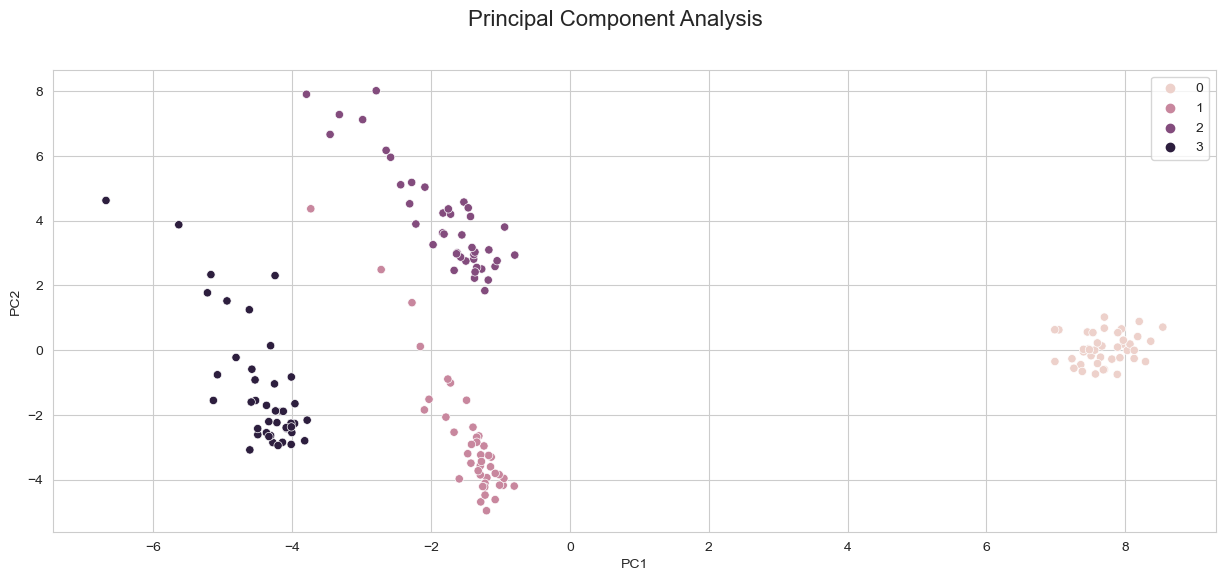

In [30]:
from sklearn.decomposition import PCA
#import plotly.express as px
from sklearn.preprocessing import StandardScaler

features = ['length','mean_stft','var_stft','tempo','rms_mean','rms_var','centroid_mean','centroid_var',\
'bandwidth_mean','bandwidth_var','rolloff_mean','rolloff_var', 'crossing_mean','crossing_var',\
'harmonic_mean','harmonic_var','contrast_mean','contrast_var','mfcc1_mean','mfcc1_var','mfcc2_mean','mfcc2_var','mfcc3_mean','mfcc3_var','mfcc4_mean','mfcc4_var',\
        'mfcc5_mean','mfcc5_var','mfcc6_mean','mfcc6_var','mfcc7_mean','mfcc7_var','mfcc8_mean','mfcc8_var',\
        'mfcc9_mean','mfcc9_var','mfcc10_mean','mfcc10_var','mfcc11_mean','mfcc11_var','mfcc12_mean','mfcc12_var',\
        'mfcc13_mean','mfcc13_var','mfcc14_mean','mfcc14_var','mfcc15_mean','mfcc15_var','mfcc16_mean','mfcc16_var',\
        'mfcc17_mean','mfcc17_var','mfcc18_mean','mfcc18_var','mfcc19_mean','mfcc19_var','mfcc20_mean','mfcc20_var']

pca = PCA()
SS = StandardScaler()
scaled_data = SS.fit_transform(df_train[features])
components = pd.DataFrame(pca.fit_transform(scaled_data))
plt.figure(figsize=(15,6)).suptitle('Principal Component Analysis', fontsize=16)
fig = sns.scatterplot(x=components[0], y=components[1], hue=label_train)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [31]:
eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(len(pca.explained_variance_))], 
        "Explained variance" : pca.explained_variance_,
        "% explained variance" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. explained variance" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
eig

,Dimension,Explained variance,% explained variance,% cum. explained variance
0,Dim1,2.162054e+01,38.0,38.0
1,Dim2,8.883739e+00,16.0,54.0
2,Dim3,6.557113e+00,12.0,66.0
3,Dim4,3.945703e+00,7.0,73.0
4,Dim5,1.531516e+00,3.0,76.0
5,Dim6,1.351853e+00,2.0,78.0
6,Dim7,1.161214e+00,2.0,80.0
7,Dim8,1.004987e+00,2.0,82.0
8,Dim9,9.051140e-01,2.0,83.0
9,Dim10,8.730602e-01,2.0,85.0


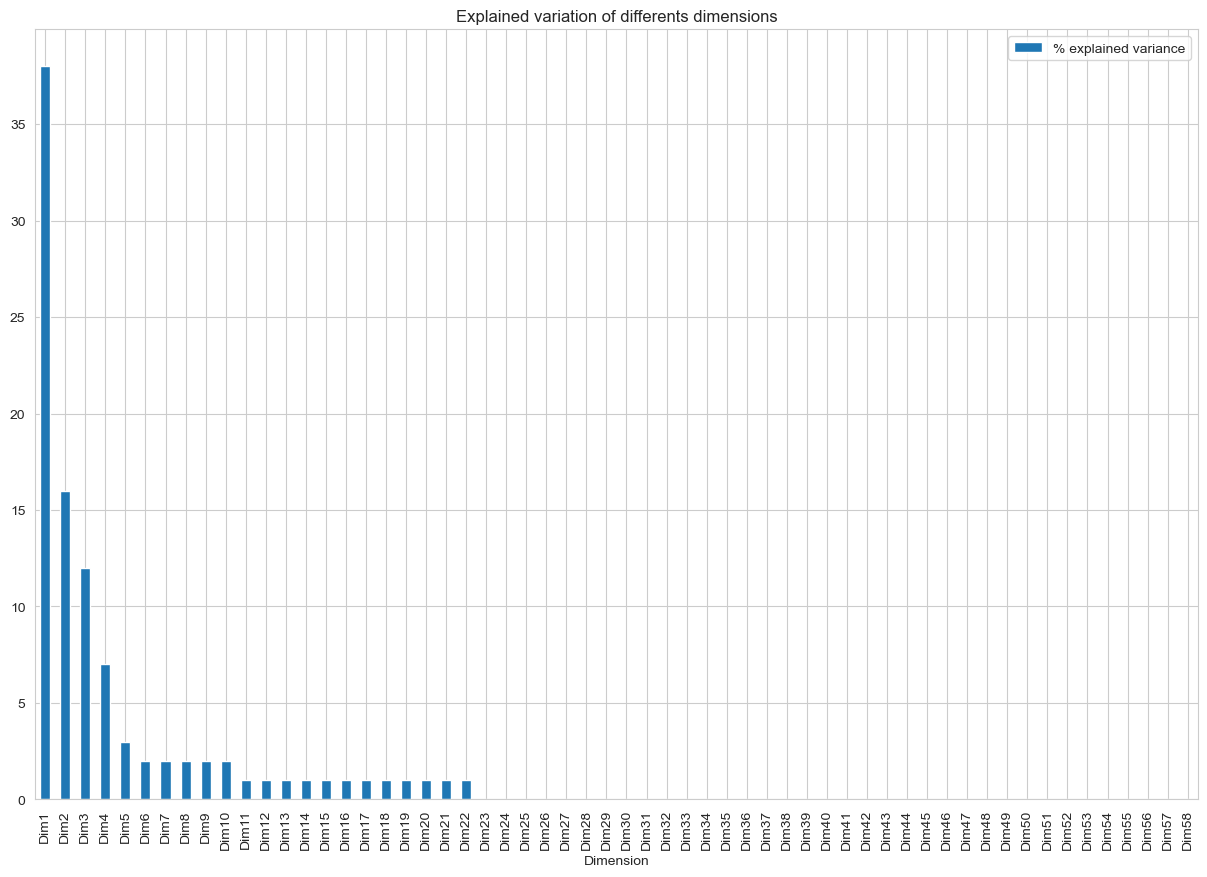

In [32]:
eig.plot.bar(x = "Dimension", y = "% explained variance",figsize=(15,10),title="Explained variation of differents dimensions") # permet un diagramme en barres
plt.show()

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=1)
mean_pca = cross_val_score(clf, components.iloc[: , :5], label_train, cv=5).mean()
mean_all = cross_val_score(clf, df_train[features].loc[:, df_train[features].columns!="type"], label_train, cv=5).mean()

pd.DataFrame({"Average precision with PCA" : [mean_pca], 
              "Average precision without PCA" : [mean_all], 
              "Number of components" : [components.shape[1]]})

,Average precision with PCA,Average precision without PCA,Number of components
0,0.976471,1.0,58


In [34]:
x_train = pd.DataFrame(pca.fit_transform(SS.fit_transform(df_train[features]))).iloc[: , :5]
x_test = pd.DataFrame(pca.transform(SS.transform(df_test[features]))).iloc[: , :5]

In [35]:
clf.fit(x_train,label_train)
y_pred = clf.predict(x_test)

Accuracy:  0.9722222222222222
Precision:  0.9736842105263157
Recall:  0.9722222222222223
F1 score:  0.9722007722007723


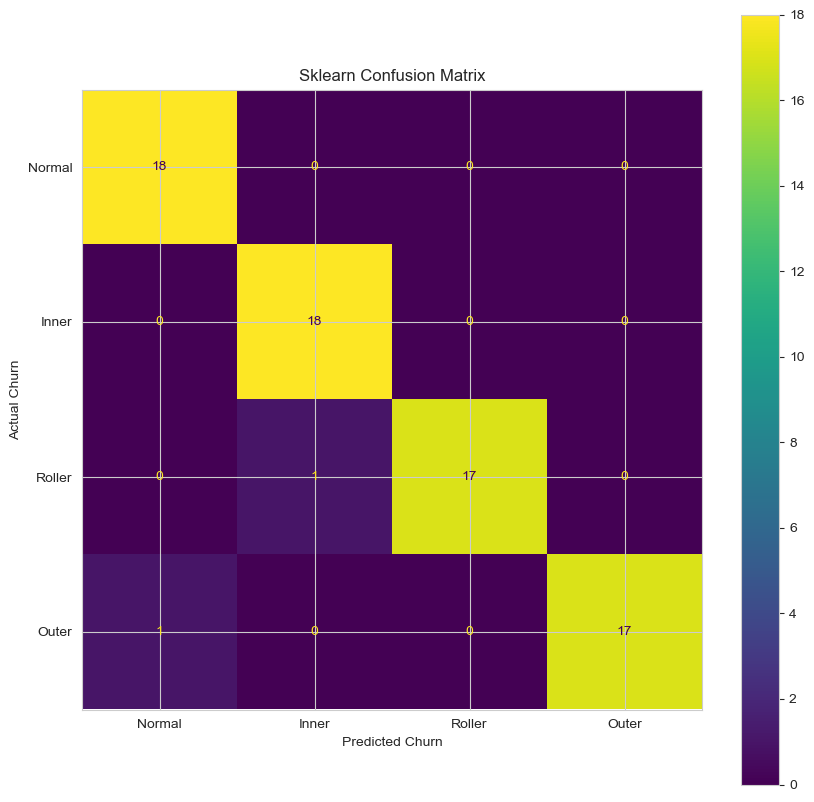

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix, ConfusionMatrixDisplay

print("Accuracy: ",accuracy_score(label_test,y_pred))
print("Precision: ",precision_score(label_test,y_pred,average='macro'))
print("Recall: ",recall_score(label_test,y_pred,average='macro'))
print("F1 score: ",f1_score(label_test,y_pred,average='macro'))

cm = confusion_matrix(label_test, y_pred)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Inner','Roller','Outer'])

fig, ax = plt.subplots(figsize=(10,10))
cmd_obj.plot(ax=ax)

cmd_obj.ax_.set(title='Sklearn Confusion Matrix', xlabel='Predicted Churn', ylabel='Actual Churn')
plt.show()

### Both Combined

In [37]:
from keras.layers import (Conv1D, MaxPool1D, Dropout, Flatten, Dense,Input, concatenate)
from keras.models import Model, Sequential

def CombineModel(input_shape,sequence_shape,classes=4):
    features = Input(sequence_shape)
    X_input = Input(input_shape)
    
    X = Conv2D(4,kernel_size=(3,3),strides=(1,1))(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(8,kernel_size=(3,3),strides=(1,1))(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(16,kernel_size=(3,3),strides = (1,1))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(32,kernel_size=(3,3),strides = (1,1))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(64,kernel_size=(3,3),strides=(1,1))(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)
    
    X = Conv2D(128,kernel_size=(3,3),strides=(1,1))(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    part1 = Flatten()(X)
    
    merged = concatenate([part1, features])
    
    final = Dense(256, activation='relu')(merged)
    final = Dropout(0.3, seed=789)(final)
    final = Dense(4, activation='softmax')(final)

    model = Model(inputs=[X_input, features], outputs=[final])

    return model

In [38]:
model = CombineModel(input_shape=(720, 216, 3),sequence_shape=(5,),classes=4)
opt = Adam(learning_rate=0.005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=["accuracy"]) 
history = model.fit(x=[np.asarray(mels_train),x_train], y=np.asarray(y_training),epochs=30, validation_split=0.2,shuffle=True,batch_size=len(mels_train),verbose=1)

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 3.1082 - accuracy: 0.2388 - val_loss: 296.4651 - val_accuracy: 0.1471
Epoch 2/30
1/1 [==============================] - 0s 358ms/step - loss: 87.7642 - accuracy: 0.2985 - val_loss: 384.4294 - val_accuracy: 0.2353
Epoch 3/30
1/1 [==============================] - 0s 368ms/step - loss: 76.6615 - accuracy: 0.2537 - val_loss: 287.6079 - val_accuracy: 0.2353
Epoch 4/30
1/1 [==============================] - 0s 350ms/step - loss: 42.8904 - accuracy: 0.4254 - val_loss: 296.2947 - val_accuracy: 0.2353
Epoch 5/30
1/1 [==============================] - 0s 356ms/step - loss: 13.8906 - accuracy: 0.4030 - val_loss: 327.5291 - val_accuracy: 0.2353
Epoch 6/30
1/1 [==============================] - 0s 356ms/step - loss: 9.2451 - accuracy: 0.3657 - val_loss: 371.8575 - val_accuracy: 0.2353
Epoch 7/30
1/1 [==============================] - 0s 354ms/step - loss: 5.5527 - accuracy: 0.4851 - val_loss: 431.1536 - val_accuracy: 0.2353
Epoch

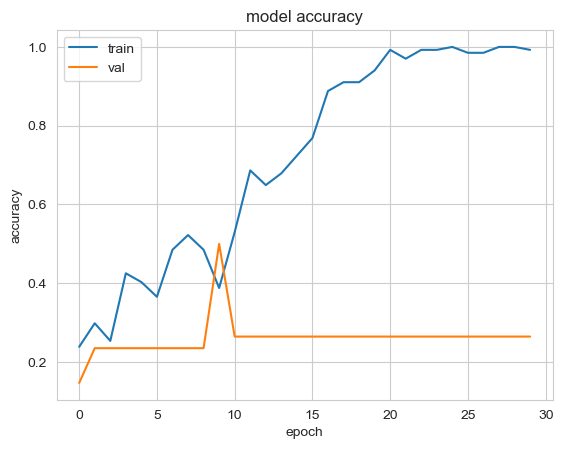

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [40]:
y_cnn = model.predict_generator([np.asarray(mels_test),x_test])
y_cnn = np.argmax(y_cnn,axis=1).tolist()

Accuracy:  0.25
Precision:  0.0625
Recall:  0.25
F1 score:  0.1


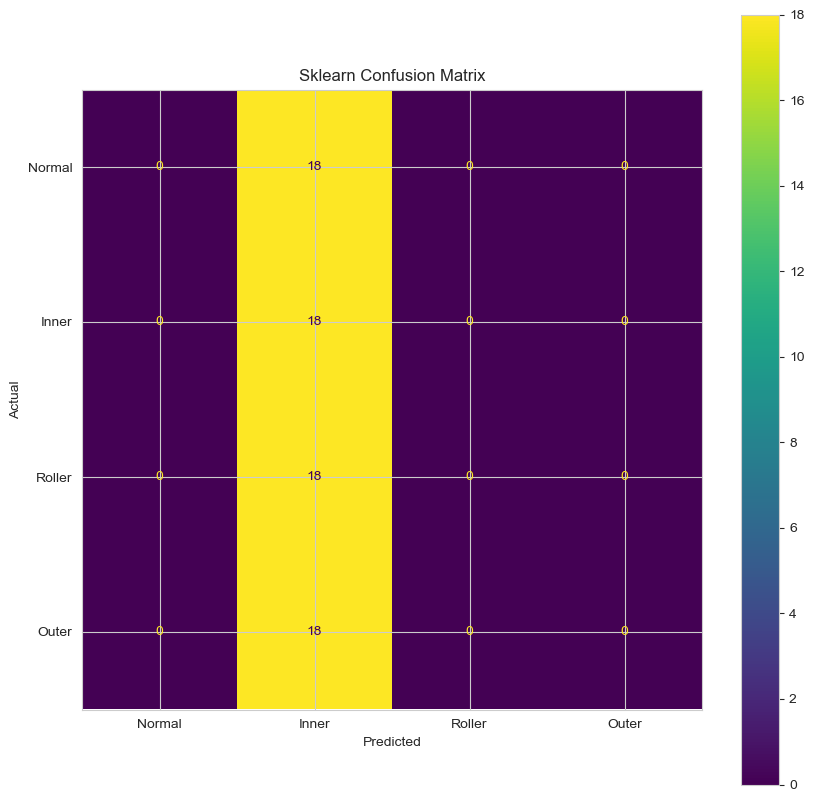

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

print("Accuracy: ",accuracy_score(label_test,y_cnn))
print("Precision: ",precision_score(label_test,y_cnn,average='macro'))
print("Recall: ",recall_score(label_test,y_cnn,average='macro'))
print("F1 score: ",f1_score(label_test,y_cnn,average='macro'))

cm = confusion_matrix(label_test, y_cnn)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Inner','Roller','Outer'])

fig, ax = plt.subplots(figsize=(10,10))
cmd_obj.plot(ax=ax)

cmd_obj.ax_.set(title='Sklearn Confusion Matrix', xlabel='Predicted', ylabel='Actual')
plt.show()

In [23]:
librosa.show_versions()

INSTALLED VERSIONS
------------------
python: 3.8.16 (default, Mar  2 2023, 03:18:16) [MSC v.1916 64 bit (AMD64)]

librosa: 0.9.2

audioread: 3.0.0
numpy: 1.23.5
scipy: 1.10.1
sklearn: 1.2.2
joblib: 1.1.1
decorator: 5.1.1
soundfile: 0.12.1
resampy: 0.4.2
numba: 0.57.0
pooch: v1.4.0
packaging: 23.0

numpydoc: None
sphinx: None
sphinx_rtd_theme: None
sphinx_multiversion: None
sphinx_gallery: None
mir_eval: None
ipython: None
sphinxcontrib-svg2pdfconverter: None
pytest: None
pytest-mpl: None
pytest-cov: None
matplotlib: 3.7.1
samplerate: None
soxr: 0.3.5
contextlib2: None
presets: None
